## Libraries

In [5]:
import pandas as pd
import numpy as np

from math import radians, cos, sin, asin, sqrt

import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

from lazypredict.Supervised import LazyRegressor

import warnings
warnings.filterwarnings('ignore')

## Data Analysis

In [6]:
trips_set = pd.read_csv('Database/Airline_price_train.csv')

In [7]:
# our dataset is in rupees i am going to convert it to euros so i can better understand the data
trips_set.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


### Target

In [8]:
# our dataset is in rupees i am going to change it to euros so i can understand
# i used an api to build a dataset in order to convert to euros

conversions = pd.read_csv('Database/conversion.csv')
conversions.head()

,Date,Rate,Base,Rate_currency
0,2019-01-03,79.14,EUR,INR
1,2019-01-04,79.79,EUR,INR
2,2019-01-05,79.79,EUR,INR
3,2019-01-06,79.79,EUR,INR
4,2019-01-07,79.20,EUR,INR


In [9]:
trips_set['Date'] = pd.to_datetime(trips_set['Date_of_Journey']).dt.date.astype('str')
trips_set[['Date', 'Date_of_Journey']]
# okay looks good ready to connect

,Date,Date_of_Journey
0,2019-03-24,24/03/2019
1,2019-05-01,1/05/2019
2,2019-06-09,9/06/2019
3,2019-05-12,12/05/2019
4,2019-03-01,01/03/2019
...,...,...
10678,2019-04-09,9/04/2019
10679,2019-04-27,27/04/2019
10680,2019-04-27,27/04/2019
10681,2019-03-01,01/03/2019


In [10]:
trips_set = trips_set.merge(conversions, on = 'Date', how = 'left')
trips_set['Price_in_EUR'] = trips_set['Price']/trips_set['Rate']

In [11]:
trips_set.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date,Rate,Base,Rate_currency,Price_in_EUR
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,2019-03-24,78.19,EUR,INR,49.84
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,2019-05-01,78.05,EUR,INR,98.17
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,2019-06-09,77.92,EUR,INR,178.16
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,2019-05-12,78.67,EUR,INR,79.04
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,2019-03-01,80.47,EUR,INR,165.31


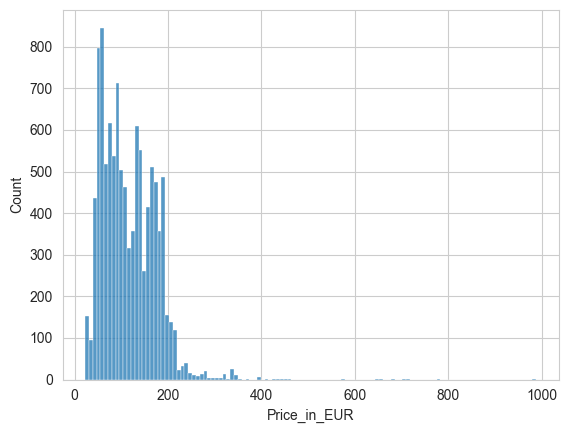

In [12]:
# histogran to evaluate target distribution
sns.set_style('whitegrid')

sns.histplot(x= trips_set['Price_in_EUR'])
plt.show()

We can see that the target is continuous, and the distribution is skewed towards the right.

We can improve the value spread with a mathematical transformation.

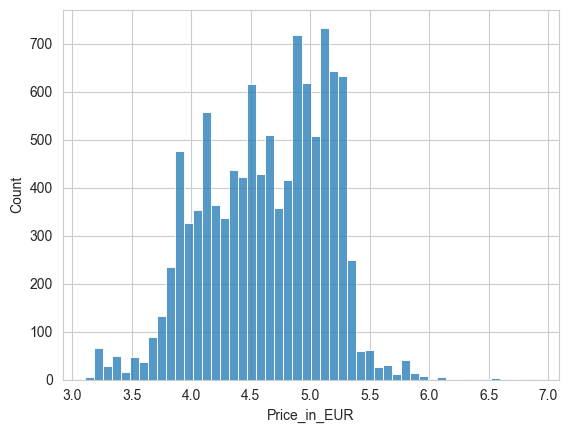

In [13]:
sns.set_style('whitegrid')

sns.histplot(x= np.log(trips_set['Price_in_EUR']))
plt.show()

In [14]:
trips_set.drop(columns= ['Date_of_Journey', 'Price', 'Rate', 'Base', 'Rate_currency'], inplace= True)

In [15]:
# let's split it before we do anything, so we don't suffer from data snooping bias

train, test = train_test_split(trips_set, test_size= 0.2, random_state= 0)

### Temporal Variables

In [16]:
time_vars = ['Date', 'Dep_Time', 'Arrival_Time', 'Duration']

In [17]:
# we can break this dates down so our ml model understands them
# and also study what is wrong with arrival_time
# someone doesn't land before they even got on the plane
train[time_vars].head()

,Date,Dep_Time,Arrival_Time,Duration
508,2019-05-21,20:20,18:50 22 May,22h 30m
3071,2019-03-24,06:35,14:25,7h 50m
2036,2019-03-06,22:50,10:25 07 Mar,11h 35m
49,2019-06-27,23:05,19:00 28 Jun,19h 55m
9686,2019-05-27,22:15,00:50 28 May,2h 35m


In [18]:
train[time_vars].isna().sum()

Date            0
Dep_Time        0
Arrival_Time    0
Duration        0
dtype: int64

In [19]:
# let's treat date and departure time

def extract_time_vars(dataset, var_date, var_time = None, name = ''):
    
    if var_time is None:
        var_time = var_date
    dataset[f'{name}_year'] = pd.to_datetime(dataset[var_date]).dt.year
    dataset[f'{name}_month'] = pd.to_datetime(dataset[var_date]).dt.month
    dataset[f'{name}_day'] = pd.to_datetime(dataset[var_date]).dt.day
    dataset[f'{name}_hours'] = pd.to_datetime(dataset[var_time]).dt.hour
    dataset[f'{name}_minutes'] = pd.to_datetime(dataset[var_time]).dt.minute
    
extract_time_vars(train, "Date", "Dep_Time", name= "Dep")
extract_time_vars(test, "Date", "Dep_Time", name= "Dep")

In [20]:
# treat the duration

def normalize_duration(row):
    if 'h' not in row:
        row =  '0h ' + row
    elif 'm' not in row:
        row = row + ' 0m'
    return row
    
    
train['Duration'] = train['Duration'].apply(lambda x: normalize_duration(x))
test['Duration'] = test['Duration'].apply(lambda x: normalize_duration(x))

def extract_time_duration(dataset):
    dataset['Duration_hours'] = dataset['Duration'].apply(lambda x: x.split(' ')[0][:-1]).astype('int64')
    dataset['Duration_minutes'] = dataset['Duration'].apply(lambda x: x.split(' ')[1][:-1]).astype('int64')

extract_time_duration(train)
extract_time_duration(test)

In [21]:
time_vars = time_vars + ['Dep_year', 'Dep_month', 'Dep_day', 'Dep_hours', 'Dep_minutes', 'Duration_hours', 'Duration_minutes']
train[time_vars].head()

,Date,Dep_Time,Arrival_Time,Duration,Dep_year,Dep_month,Dep_day,Dep_hours,Dep_minutes,Duration_hours,Duration_minutes
508,2019-05-21,20:20,18:50 22 May,22h 30m,2019,5,21,20,20,22,30
3071,2019-03-24,06:35,14:25,7h 50m,2019,3,24,6,35,7,50
2036,2019-03-06,22:50,10:25 07 Mar,11h 35m,2019,3,6,22,50,11,35
49,2019-06-27,23:05,19:00 28 Jun,19h 55m,2019,6,27,23,5,19,55
9686,2019-05-27,22:15,00:50 28 May,2h 35m,2019,5,27,22,15,2,35


In [22]:
# Analyse our arrival date
train['Arr_Date'] = train.apply(lambda x: pd.to_datetime(x['Date'] + ' ' + x['Arrival_Time']) if len(x['Arrival_Time']) == 5 else pd.to_datetime(x['Arrival_Time'] + ' ' + str(x['Dep_year'])), axis = 1)

In [23]:
# okay only 68 rows have that weird pattern in our trainset
train.query('Date > Arr_Date')[['Date', 'Dep_Time', 'Arrival_Time', 'Arr_Date', 'Duration']]

,Date,Dep_Time,Arrival_Time,Arr_Date,Duration
10660,2019-03-21,21:10,00:05 19 Mar,2019-03-19 00:05:00,2h 55m
2588,2019-03-18,11:40,09:00 16 Mar,2019-03-16 09:00:00,21h 20m
1538,2019-03-18,06:45,11:10 16 Mar,2019-03-16 11:10:00,28h 25m
2095,2019-03-21,08:55,07:40 19 Mar,2019-03-19 07:40:00,22h 45m
5464,2019-03-21,22:00,23:20 19 Mar,2019-03-19 23:20:00,25h 20m
...,...,...,...,...,...
9198,2019-03-21,08:15,11:20 19 Mar,2019-03-19 11:20:00,27h 5m
21,2019-03-21,22:00,13:20 19 Mar,2019-03-19 13:20:00,15h 20m
4723,2019-03-21,14:05,07:40 19 Mar,2019-03-19 07:40:00,17h 35m
2353,2019-03-21,16:55,11:25 19 Mar,2019-03-19 11:25:00,18h 30m


In [24]:
# correct the Arrival date using the duration
train['correct_arr_date'] = train.apply(lambda x: pd.to_datetime(x['Date'] + ' ' + x['Dep_Time']) 
                                                + pd.Timedelta(hours= x['Duration_hours']
                                                               , minutes= x['Duration_minutes']) 
                                                , axis=1)
test['correct_arr_date'] = test.apply(lambda x: pd.to_datetime(x['Date'] + ' ' + x['Dep_Time']) 
                                                + pd.Timedelta(hours= x['Duration_hours']
                                                               , minutes= x['Duration_minutes']) 
                                                , axis=1)

In [25]:
train.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Date,Price_in_EUR,Dep_year,Dep_month,Dep_day,Dep_hours,Dep_minutes,Duration_hours,Duration_minutes,Arr_Date,correct_arr_date
508,Vistara,Kolkata,Banglore,CCU → DEL → BLR,20:20,18:50 22 May,22h 30m,1 stop,No info,2019-05-21,120.33,2019,5,21,20,20,22,30,2019-05-22 18:50:00,2019-05-22 18:50:00
3071,GoAir,Kolkata,Banglore,CCU → HYD → BLR,06:35,14:25,7h 50m,1 stop,No info,2019-03-24,61.05,2019,3,24,6,35,7,50,2019-03-24 14:25:00,2019-03-24 14:25:00
2036,Jet Airways,Banglore,New Delhi,BLR → BOM → DEL,22:50,10:25 07 Mar,11h 35m,1 stop,No info,2019-03-06,216.77,2019,3,6,22,50,11,35,2019-03-07 10:25:00,2019-03-07 10:25:00
49,Jet Airways,Delhi,Cochin,DEL → AMD → BOM → COK,23:05,19:00 28 Jun,19h 55m,2 stops,In-flight meal not included,2019-06-27,141.77,2019,6,27,23,5,19,55,2019-06-28 19:00:00,2019-06-28 19:00:00
9686,IndiGo,Kolkata,Banglore,CCU → BLR,22:15,00:50 28 May,2h 35m,non-stop,No info,2019-05-27,62.55,2019,5,27,22,15,2,35,2019-05-28 00:50:00,2019-05-28 00:50:00


In [26]:
# this are all the other examples that we didn't get in the 
# other query but where the values are also wrong
# okay it doesn't make sence that the flight took a bit more than 3 days and costed 55 EUR
# as opposed to the 2nd row where the duration as a bit more than 1 days and costed 116 EUR
# so i will trust Duration over Arrival_date, since it's also correct for the other 10k rows
display(train.query('correct_arr_date != Arr_Date & Date < Arr_Date')[['Date', 'Dep_Time', 'Arrival_Time', 'Arr_Date', 'correct_arr_date', 'Duration', 'Price_in_EUR']].head())
print(len(train.query('correct_arr_date != Arr_Date & Date < Arr_Date')))

,Date,Dep_Time,Arrival_Time,Arr_Date,correct_arr_date,Duration,Price_in_EUR
1116,2019-03-09,21:20,00:15 13 Mar,2019-03-13 00:15:00,2019-03-10 00:15:00,2h 55m,60.90
7497,2019-03-03,08:00,05:05 07 Mar,2019-03-07 05:05:00,2019-03-04 05:05:00,21h 5m,167.80
8118,2019-03-09,23:30,02:20 13 Mar,2019-03-13 02:20:00,2019-03-10 02:20:00,2h 50m,60.90
10424,2019-03-03,17:25,08:45 07 Mar,2019-03-07 08:45:00,2019-03-04 08:45:00,15h 20m,143.79
1837,2019-03-09,17:00,16:40 13 Mar,2019-03-13 16:40:00,2019-03-10 16:40:00,23h 40m,118.46


46


In [27]:
# extract information from the correct time

extract_time_vars(train, "correct_arr_date",  name= "Arv")
extract_time_vars(test, "correct_arr_date", name= "Arv")

In [28]:
time_vars = time_vars + ['Arv_year', 'Arv_month', 'Arv_day', 'Arv_hours', 'Arv_minutes', 'correct_arr_date', 'Arr_Date']
train[time_vars].head()

,Date,Dep_Time,Arrival_Time,Duration,Dep_year,Dep_month,Dep_day,Dep_hours,Dep_minutes,Duration_hours,Duration_minutes,Arv_year,Arv_month,Arv_day,Arv_hours,Arv_minutes,correct_arr_date,Arr_Date
508,2019-05-21,20:20,18:50 22 May,22h 30m,2019,5,21,20,20,22,30,2019,5,22,18,50,2019-05-22 18:50:00,2019-05-22 18:50:00
3071,2019-03-24,06:35,14:25,7h 50m,2019,3,24,6,35,7,50,2019,3,24,14,25,2019-03-24 14:25:00,2019-03-24 14:25:00
2036,2019-03-06,22:50,10:25 07 Mar,11h 35m,2019,3,6,22,50,11,35,2019,3,7,10,25,2019-03-07 10:25:00,2019-03-07 10:25:00
49,2019-06-27,23:05,19:00 28 Jun,19h 55m,2019,6,27,23,5,19,55,2019,6,28,19,0,2019-06-28 19:00:00,2019-06-28 19:00:00
9686,2019-05-27,22:15,00:50 28 May,2h 35m,2019,5,27,22,15,2,35,2019,5,28,0,50,2019-05-28 00:50:00,2019-05-28 00:50:00


In [29]:
train.drop(columns = ['Dep_Time', 'Arrival_Time', 'Duration', 'Date', 'Arr_Date', 'correct_arr_date'], inplace= True)
test.drop(columns = ['Dep_Time', 'Arrival_Time', 'Duration', 'Date', 'correct_arr_date'], inplace= True)

In [30]:
for var in ['Dep_Time', 'Arrival_Time', 'Duration', 'Date', 'Arr_Date', 'correct_arr_date']: 
    time_vars.remove(var)

In [31]:
# Dep_year and Arv_year only have 1 value
train[time_vars].describe()

,Dep_year,Dep_month,Dep_day,Dep_hours,Dep_minutes,Duration_hours,Duration_minutes,Arv_year,Arv_month,Arv_day,Arv_hours,Arv_minutes
count,8546.00,8546.00,8546.00,8546.00,8546.00,8546.00,8546.00,8546.00,8546.00,8546.00,8546.00,8546.00
mean,2019.00,4.71,13.56,12.45,24.37,10.18,28.26,2019.00,4.71,13.97,13.33,24.73
std,0.00,1.16,8.43,5.75,18.81,8.47,16.94,0.00,1.16,8.44,6.86,16.47
min,2019.00,3.00,1.00,0.00,0.00,0.00,0.00,2019.00,3.00,1.00,0.00,0.00
25%,2019.00,3.00,6.00,8.00,5.00,2.00,15.00,2019.00,3.00,7.00,8.00,15.00
50%,2019.00,5.00,12.00,11.00,25.00,8.00,30.00,2019.00,5.00,13.00,14.00,25.00
75%,2019.00,6.00,21.00,17.00,40.00,15.00,45.00,2019.00,6.00,21.00,19.00,35.00
max,2019.00,6.00,27.00,23.00,55.00,47.00,55.00,2019.00,6.00,29.00,23.00,55.00


In [32]:
train.drop(columns = ['Dep_year', 'Arv_year'], inplace= True)
test.drop(columns = ['Dep_year', 'Arv_year'], inplace= True)

In [33]:
train.head(3)

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price_in_EUR,Dep_month,Dep_day,Dep_hours,Dep_minutes,Duration_hours,Duration_minutes,Arv_month,Arv_day,Arv_hours,Arv_minutes
508,Vistara,Kolkata,Banglore,CCU → DEL → BLR,1 stop,No info,120.33,5,21,20,20,22,30,5,22,18,50
3071,GoAir,Kolkata,Banglore,CCU → HYD → BLR,1 stop,No info,61.05,3,24,6,35,7,50,3,24,14,25
2036,Jet Airways,Banglore,New Delhi,BLR → BOM → DEL,1 stop,No info,216.77,3,6,22,50,11,35,3,7,10,25


### Categorical Variables

In [34]:
cat_vars = ['Airline', 'Source', 'Destination', 'Route', 'Total_Stops', 'Additional_Info']

In [35]:
train[cat_vars].isna().sum()

Airline            0
Source             0
Destination        0
Route              1
Total_Stops        1
Additional_Info    0
dtype: int64

In [36]:
# okay it ends up that both null values are on the same row.
# well the flight takes 23 hours so we can replace the route by the source-destination
train[train.isna().any(axis=1)]

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price_in_EUR,Dep_month,Dep_day,Dep_hours,Dep_minutes,Duration_hours,Duration_minutes,Arv_month,Arv_day,Arv_hours,Arv_minutes
9039,Air India,Delhi,Cochin,NaN,NaN,No info,96.71,5,6,9,45,23,40,5,7,9,25


In [37]:
# are going to drop null values in this case since it's just 1 row
train.dropna(inplace=True)
test.dropna(inplace=True)

In [38]:
# all the columns except Route and Additional_info seem to be usefull
# Route has way to many unique values and additional_info is 80% filled with `No info``
train[cat_vars].describe(include='O')

,Airline,Source,Destination,Route,Total_Stops,Additional_Info
count,8545,8545,8545,8545,8545,8545
unique,12,5,6,124,4,10
top,Jet Airways,Delhi,Cochin,DEL → BOM → COK,1 stop,No info
freq,3065,3626,3626,1909,4510,6680


In [39]:
# since routes has so many uniques i am going to analyse all the other variables
_ = cat_vars.copy()
_.remove('Route')

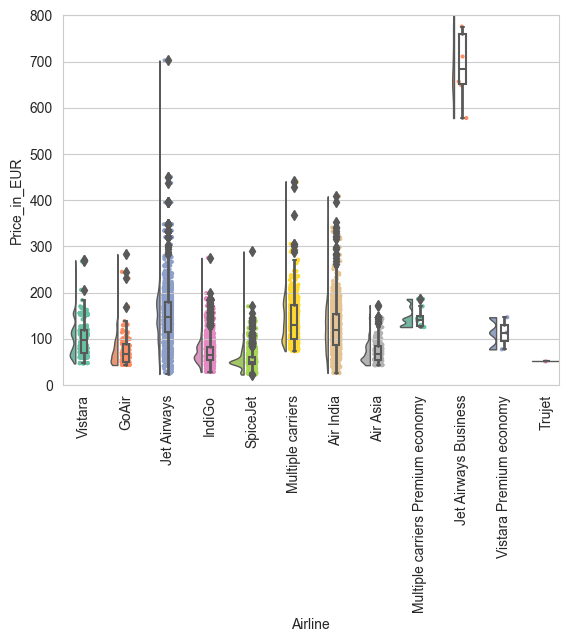

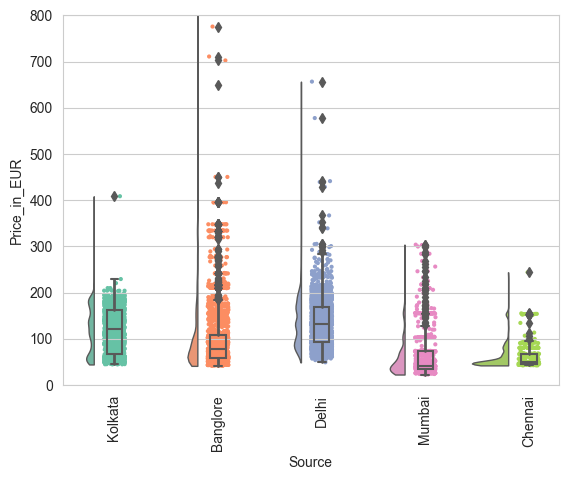

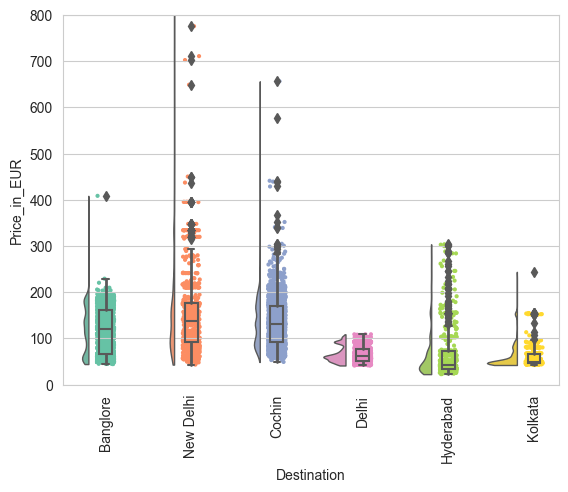

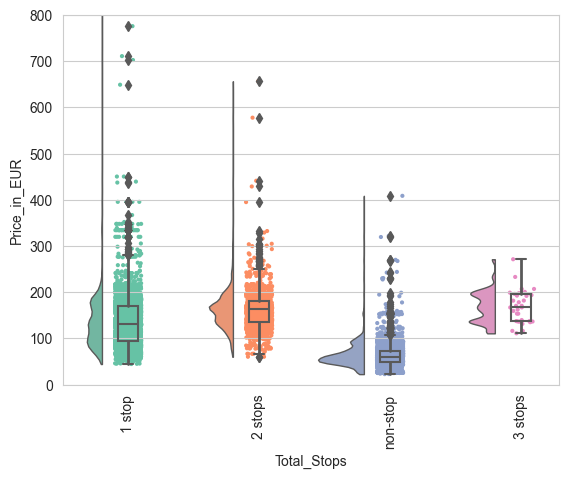

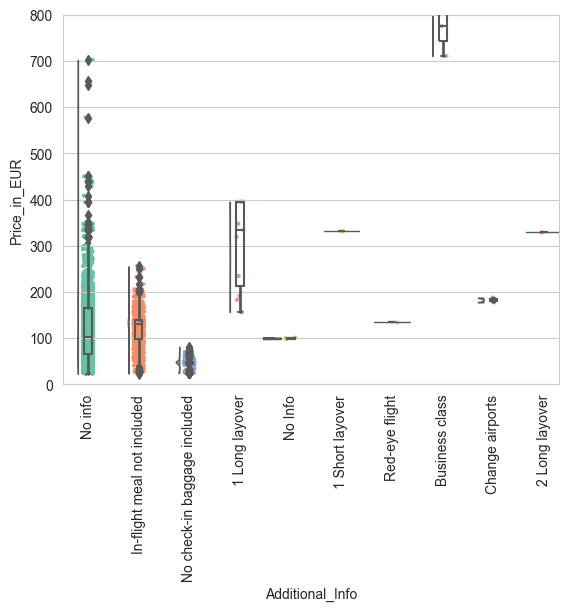

In [40]:
# there is not such a clear distinction between them
# we can see that indigo is cheaper than multiple carriers but it's not as noticable as i would have liked
# we can also see that flights come from chennai tend to be cheaper than new delhi
for var in _:
    pt.RainCloud(x= var, y= 'Price_in_EUR', data=train)
    plt.xticks(rotation=90)
    plt.ylim(0,800) # remove the celling so i can visualize it better
    plt.show()
    

In [41]:
# some categories in airlines and additional_info have little data points so we are going to group them
def analyse_rare_labels(df, var, rare_perc):
    df = df.copy()

    # determine the % of observations per category
    # tmp = df.groupby(var)['SalePrice'].count() /len(df)
    tmp = df[var].value_counts(normalize=True)
    tmp.name = var
    # return categories that are rare
    return tmp[tmp < rare_perc]

for var in _:
    display(analyse_rare_labels(train, var, 0.01))

# okay total_stops only has 1 rare label so replacing it by Rare would be the same as leaving it

Airline
Multiple carriers Premium economy   0.00
Jet Airways Business                0.00
Vistara Premium economy             0.00
Trujet                              0.00
Name: Airline, dtype: float64

Series([], Name: Source, dtype: float64)

Series([], Name: Destination, dtype: float64)

Total_Stops
3 stops   0.00
Name: Total_Stops, dtype: float64

Additional_Info
1 Long layover    0.00
No Info           0.00
Business class    0.00
Change airports   0.00
1 Short layover   0.00
Red-eye flight    0.00
2 Long layover    0.00
Name: Additional_Info, dtype: float64

In [42]:
def find_frequent_labels(df, var, rare_perc):

    # function finds the labels that are shared by more than
    # a certain % of the houses in the dataset

    df = df.copy()

    tmp = df[var].value_counts(normalize= True)
    
    return tmp[tmp > rare_perc].index

for var in ['Airline', 'Additional_Info']:

    # find the frequent categories
    frequent_ls = find_frequent_labels(train, var, 0.01)

    print(var, frequent_ls)
    print()

    # replace rare categories by the string "Rare"

    train[var] = np.where(train[var].isin(frequent_ls), train[var], 'Rare')
    test[var] = np.where(test[var].isin(frequent_ls), test[var], 'Rare')

Airline Index(['Jet Airways', 'IndiGo', 'Air India', 'Multiple carriers', 'SpiceJet',
       'Vistara', 'Air Asia', 'GoAir'],
      dtype='object', name='Airline')

Additional_Info Index(['No info', 'In-flight meal not included',
       'No check-in baggage included'],
      dtype='object', name='Additional_Info')



In [43]:
train.Airline.value_counts()

Airline
Jet Airways          3065
IndiGo               1661
Air India            1374
Multiple carriers     966
SpiceJet              661
Vistara               379
Air Asia              259
GoAir                 158
Rare                   22
Name: count, dtype: int64

**Note:** 

this is important, because when we divide the dataset into train and test, what happens is that we have some of

the rare labels in the training dataset that are not in the test dataset, which could cost overfitting.

But more importantly, those that are present in the test said we will not know how to transform them

into numbers because we set up our pipeline over the train dataset and then we won't be able to score them.

So we need to tackle rare labels when we do feature engineering

In [44]:
# cleaning total_stops
train['Total_Stops'] = train['Total_Stops'].apply(lambda x: '0' if x == 'non-stop' else x[0]).astype(int)
test['Total_Stops'] = test['Total_Stops'].apply(lambda x: '0' if x == 'non-stop' else x[0]).astype(int)

In [45]:
train.Total_Stops.value_counts()

Total_Stops
1    4510
0    2810
2    1190
3      35
Name: count, dtype: int64

In [46]:
# Airlines, Total_Stops and Additional_info is done, 
# let's check if Source and Destination need cleaning with the help of Route
train["Route"] = train.Route.str.split(' → ')
test["Route"] = test.Route.str.split(' → ')
train[cat_vars]

,Airline,Source,Destination,Route,Total_Stops,Additional_Info
508,Vistara,Kolkata,Banglore,"[CCU, DEL, BLR]",1,No info
3071,GoAir,Kolkata,Banglore,"[CCU, HYD, BLR]",1,No info
2036,Jet Airways,Banglore,New Delhi,"[BLR, BOM, DEL]",1,No info
49,Jet Airways,Delhi,Cochin,"[DEL, AMD, BOM, COK]",2,In-flight meal not included
9686,IndiGo,Kolkata,Banglore,"[CCU, BLR]",0,No info
...,...,...,...,...,...,...
9225,Jet Airways,Kolkata,Banglore,"[CCU, BOM, BLR]",1,In-flight meal not included
4859,Air India,Delhi,Cochin,"[DEL, GOI, BOM, COK]",2,No info
3264,Jet Airways,Delhi,Cochin,"[DEL, BOM, COK]",1,No info
9845,Jet Airways,Delhi,Cochin,"[DEL, BOM, COK]",1,In-flight meal not included


In [47]:
_ = train[['Source', 'Destination', 'Route']].copy()

In [48]:
_['Route_Source'] = _['Route'].apply(lambda x: x[0])
_['Route_Destination'] = _['Route'].apply(lambda x: x[-1])

In [49]:
_.groupby(['Source', 'Route_Source']).count()

,,Destination,Route,Route_Destination
Source,Route_Source,,,
Banglore,BLR,1764,1764,1764
Chennai,MAA,308,308,308
Delhi,DEL,3626,3626,3626
Kolkata,CCU,2288,2288,2288
Mumbai,BOM,559,559,559


In [50]:
# if i were in snowflake i would just do 
# select col1, listing(distinct col2, ',') from table group by 1
_.groupby('Route_Source')['Source'].agg(lambda x: ', '.join(x.unique())).sort_values()

Route_Source
BLR    Banglore
MAA     Chennai
DEL       Delhi
CCU     Kolkata
BOM      Mumbai
Name: Source, dtype: object

In [51]:
# Source is fine, but destination airport is the same in New Delhi and Delhi
# which makes sense since New Delhi is a part of Delhi
_.groupby('Route_Destination')['Destination'].agg(lambda x: ', '.join(x.unique())).sort_values()

Route_Destination
BLR            Banglore
COK              Cochin
HYD           Hyderabad
CCU             Kolkata
DEL    New Delhi, Delhi
Name: Destination, dtype: object

In [52]:
# let's clean it
train["Destination"] = np.where(train["Destination"] == 'New Delhi', 'Delhi',  train["Destination"])
test["Destination"] = np.where(test["Destination"] == 'New Delhi', 'Delhi',  test["Destination"])

In [53]:
train["Destination"].value_counts()

Destination
Cochin       3626
Banglore     2288
Delhi        1764
Hyderabad     559
Kolkata       308
Name: count, dtype: int64

In [54]:
# okay Airlines, Total_Stops, Additional_info, Source and Destination are cleaned
# now we just need to take care of Route
# we have 128 unique values but how many unique 3 letter city codes do we have?
# okay we still got a bunch we can't just do one hot encoding for each due to curse of dimemsionality
s = set()
for item in train.Route:
    for _ in item:
        s.add(_)
len(s)

42

In [55]:
airports = pd.read_csv('Database/IndianAirports.csv')
airports.head()

,IATA Code,Latitude Decimal Degrees,Longitude Decimal Degrees
0,TRV,8.48,76.92
1,COK,10.15,76.39
2,IXZ,11.65,92.73
3,BLR,12.95,77.67
4,MAA,12.99,80.18


In [56]:
# we can use the 3 letter airport codes to get the location and calculate the distance traveled

def distance(lat1, lat2, lon1, lon2):
	
	# The math module contains a function named
	# radians which converts from degrees to radians.
	lon1 = radians(lon1)
	lon2 = radians(lon2)
	lat1 = radians(lat1)
	lat2 = radians(lat2)
	
	# Haversine formula
	dlon = lon2 - lon1
	dlat = lat2 - lat1
	a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2

	c = 2 * asin(sqrt(a))
	
	# Radius of earth in kilometers.
	r = 6371
	
	return(c * r)

# in order to get the latitude and longitude i am goint to transform the 3 letter code as indexes to do lookups
airports_lookup = airports.set_index("IATA Code")
 
def distance_km(lst):
    first_lookup = lst[0]
    n = 0
    for item in lst[1:]:
        lat1, lon1 = airports_lookup.loc[first_lookup]
        lat2, lon2 = airports_lookup.loc[item]
        first_lookup = item
        n += distance(lat1, lat2, lon1, lon2)
    return round(n, 2)

train['Distance_in_km'] = train['Route'].apply(distance_km)
test['Distance_in_km'] = test['Route'].apply(distance_km)

In [57]:
# even tho we have cleaned all the categories some are still in string format
# we are going to do ordinal encoding base on the target mean
train.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price_in_EUR,Dep_month,Dep_day,Dep_hours,Dep_minutes,Duration_hours,Duration_minutes,Arv_month,Arv_day,Arv_hours,Arv_minutes,Distance_in_km
508,Vistara,Kolkata,Banglore,"[CCU, DEL, BLR]",1,No info,120.33,5,21,20,20,22,30,5,22,18,50,3050.08
3071,GoAir,Kolkata,Banglore,"[CCU, HYD, BLR]",1,No info,61.05,3,24,6,35,7,50,3,24,14,25,1699.98
2036,Jet Airways,Banglore,Delhi,"[BLR, BOM, DEL]",1,No info,216.77,3,6,22,50,11,35,3,7,10,25,1991.86
49,Jet Airways,Delhi,Cochin,"[DEL, AMD, BOM, COK]",2,In-flight meal not included,141.77,6,27,23,5,19,55,6,28,19,0,2264.23
9686,IndiGo,Kolkata,Banglore,"[CCU, BLR]",0,No info,62.55,5,27,22,15,2,35,5,28,0,50,1569.20


In [58]:
for var in ['Airline', 'Source', 'Destination', 'Additional_Info']:
    ordinal_mapping = {label: index for index, label in enumerate(train.groupby(var)['Price_in_EUR'].mean().sort_values().index)}
    
    train[var] = train[var].map(ordinal_mapping)
    test[var] = test[var].map(ordinal_mapping)

In [59]:
X_train = train.drop(['Route', 'Price_in_EUR'], axis = 1)
y_train = train['Price_in_EUR']

X_test = test.drop(['Route', 'Price_in_EUR'], axis = 1)
y_test = test['Price_in_EUR']

In [60]:
#scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [61]:
# scale down our features
X_train = pd.DataFrame(data = scaler.transform(X_train), columns = scaler.get_feature_names_out())
y_train = np.log(y_train)

X_test = pd.DataFrame(data = scaler.transform(X_test), columns = scaler.get_feature_names_out())
y_test = np.log(y_test)

In [63]:
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RandomForestRegressor,0.95,0.95,0.12,3.47
ExtraTreesRegressor,0.95,0.95,0.12,3.11
XGBRegressor,0.94,0.94,0.12,1.28
BaggingRegressor,0.94,0.94,0.13,0.82
HistGradientBoostingRegressor,0.93,0.93,0.13,0.56
LGBMRegressor,0.93,0.93,0.13,0.25
DecisionTreeRegressor,0.91,0.91,0.15,0.15
ExtraTreeRegressor,0.89,0.89,0.17,0.10
NuSVR,0.89,0.89,0.17,8.76


In [72]:
rf = RandomForestRegressor()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=kf,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", -grid_search.best_score_)

Best Hyperparameters:  {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Score:  0.01647039552698375


In [73]:
clf = grid_search.best_estimator_
y_pred = clf.predict(X_test)

print(f"R2 Score: {r2_score(np.exp(y_test), np.exp(y_pred)):.0%}")
print(f"Mean Absolute Percentage Error: {mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred)):.0%}")
print(f"Mean Absolute Error: {mean_absolute_error(np.exp(y_test), np.exp(y_pred)):.0f} €")
print(f"Mean Squared Error: {mean_squared_error(np.exp(y_test), np.exp(y_pred)):.0f} €")
print(f"Root Mean Squared Error: {mean_squared_error(np.exp(y_test), np.exp(y_pred), squared=False):.0f} €")

R2 Score: 90%
Mean Absolute Percentage Error: 7%
Mean Absolute Error: 8 €
Mean Squared Error: 336 €
Root Mean Squared Error: 18 €


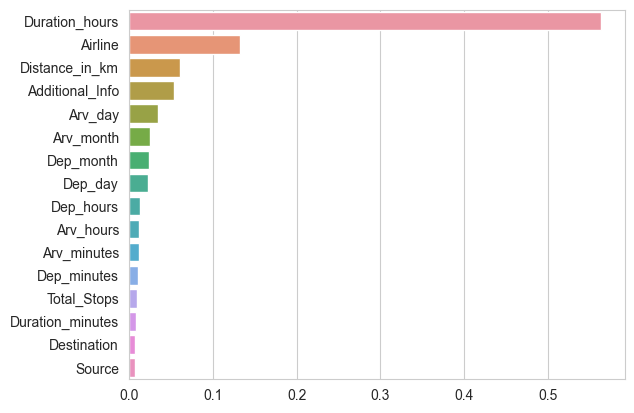

In [69]:
# importance based on the impurity calculated along each node
_ = pd.Series(clf.feature_importances_, index = X_train.columns).sort_values(ascending=False)
sns.barplot(x = _.values, y = _.index)
plt.show()

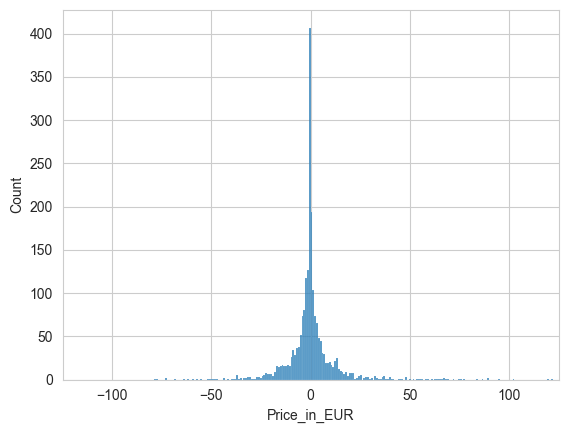

In [70]:
sns.histplot(np.exp(y_test) - np.exp(y_pred))
plt.xlim(-125, 125)
plt.show()

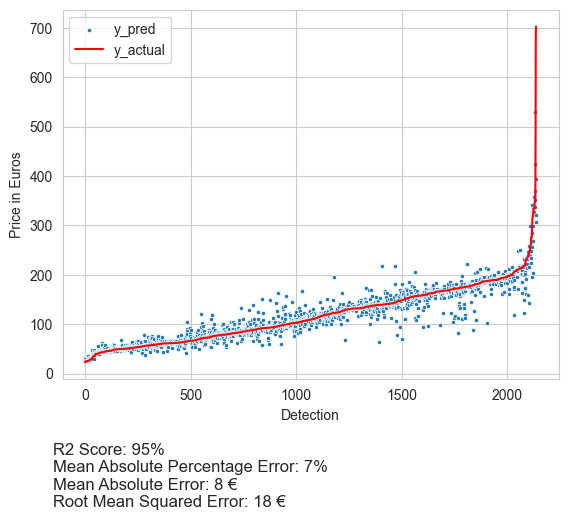

In [74]:
tmp = y_test.copy().to_frame()
tmp.rename({'Price_in_EUR': 'ActualPrice'}, axis=1, inplace=True)
tmp['PredPrice'] = y_pred
tmp[['ActualPrice', 'PredPrice']] = np.exp(tmp)
tmp = tmp.sort_values('ActualPrice').reset_index(drop=True)
tmp

sns.set_style("whitegrid")

sns.scatterplot(x = tmp.index, y= 'PredPrice',data= tmp,  marker= '.', label = 'y_pred')
sns.lineplot(x = tmp.index, y= 'ActualPrice',data= tmp, color= 'r', label= 'y_actual')

plt.ylabel('Price in Euros')
plt.xlabel('Detection')

_text = f"""
R2 Score: {r2_score(y_test, y_pred):.0%} # 90% if we transform y_test, y_pred to euros, doing this so it matches our lazypredict model comparison
Mean Absolute Percentage Error: {mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred)):.0%}
Mean Absolute Error: {mean_absolute_error(np.exp(y_test), np.exp(y_pred)):.0f} €
Root Mean Squared Error: {mean_squared_error(np.exp(y_test), np.exp(y_pred), squared=False):.0f} €"""

plt.text(-150, -270, _text, fontsize=12)
plt.show()